# New k-mer extension that happens more globally
Make it run faster.

Steps:
1. Index the database 
2. Build a hash table of the masses of all b+, b++, y+, and y++ ions and masses
3. Search for all sequences that get mass hits
4. Filter the results
5. Attempt aligments


In [1]:
# -*- coding: latin-1 -*-
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.types.database import Database
from src.types.objects import Spectrum
from src.file_io import fasta
from modules.sequence_generation import proteins, peptides
from src.spectra.gen_spectra import gen_spectrum
from src.scoring.scoring import score_subsequence

import math
from collections import namedtuple, defaultdict, deque
import time
import bisect
from operator import itemgetter
from typing import Iterable, Any


## Utils

In [2]:
def binary_search_by_key(value: Any, a: Iterable, key: str) -> int:
    '''
    index of insertion
    '''
    if len(a) == 0:
        return 0
    elif len(a) == 1:
        return 1 if getattr(a[0], key) <= getattr(value, key) else 0
    
    mid = floor(len(a)/2)
    if getattr(a[mid-1], key) <= getattr(value, key) <= getattr(a[mid], key):
        return mid
    elif getattr(a[mid], key) > getattr(value, key):
        return mid - insort_by_key(value, a[:mid], key)
    else:
        return mid + insort_by_key(value, a[mid:], key)

In [3]:
def insort_by_key(value: Any, a: Iterable, key: str) -> Iterable:
    '''
    '''
    if len(a) == 0:
        return [value]
    elif len(a) == 1:
        return a + [value] if getattr(a[0], key) <= getattr(value, key) else [value] + a
    
    mid = math.floor(len(a)/2)
    if getattr(a[mid-1], key) <= getattr(value, key) <= getattr(a[mid], key):
        return a[:mid] + [value] + a[mid:]
    elif getattr(a[mid], key) > getattr(value, key):
        return insort_by_key(value, a[:mid], key) + a[mid:]
    else:
        return a[:mid] + insort_by_key(value, a[mid:], key)

In [4]:
def insort_by_index(value: Any, a: Iterable, index: int) -> Iterable:
    '''
    '''
    if len(a) == 0:
        return [value]
    elif len(a) == 1:
        return a + [value] if a[0][index] <= value[index] else [value] + a
    
    mid = math.floor(len(a)/2)
    if a[mid-1][index] <= value[index] <= a[mid][index]:
        return a[:mid] + [value] + a[mid:]
    elif a[mid][index] > value[index]:
        return insort_by_index(value, a[:mid], index) + a[mid:]
    else:
        return a[:mid] + insort_by_index(value, a[mid:], index)

In [5]:
def binary_search_exact_by_key(value: Any, a: Iterable, key: str) -> int:
    '''
    '''
    if len(a) == 0:
        return -1
    i = bisect.bisect_left([getattr(x, key) for x in a], value)
    if i < len(a) and getattr(a[i], key) == value:
        return i
    elif i+1 < len(a) and getattr(a[i+1], key) == value:
        return i+1
    return -1

## Global extension and addition

In [6]:

MassSequence = namedtuple('MassSequence', ['mass', 'sequence'])

def ppm_to_da(reference: float, ppm_tolerance: float) -> float:
    '''
    Calculate the ppm difference between the observed and actual
    '''
    return abs((ppm_tolerance / 1000000)*reference)


def search_kmers_hash(observed: Spectrum, kmers: dict, tolerance: float) -> list:
    '''
    Search through all of the base kmers and find those that gave us good hits
    
    Inputs:
        spectrum:    (Spectrum) what to sequence
        allbasemers: (dict of list of MassSequence) all of the basemers made from the function 'make_all_base_mers_hash'
        tolerance:   (float) the ppm tolerance to accept for each mass
    Outputs:
        list of MassSequence for all masses that were in the acceptable range of an observed mass
    '''
    hits = []
    for mass in observed.spectrum:
        tol = ppm_to_da(mass, tolerance)
        lb_mass = mass - tol
        ub_mass = mass + tol
        lb_mass_key = math.floor(lb_mass)
        ub_mass_key = math.floor(ub_mass)
        hits += [x.sequence for x in kmers[ub_mass_key] if lb_mass <= x.mass <= ub_mass]
        if lb_mass_key != ub_mass_key:
            hits += [x.sequence for x in kmers[ub_mass_key] if lb_mass <= x.mass <= ub_mass]
            
    return hits

## Build a dictionary for sizes min length to max length

In [7]:
KmerMasses = namedtuple('KmerMasses', ['bs', 'bd', 'ys', 'yd'])

def add_sequence_to_masssequences(l: list, sequence: str, mass: float) -> list:
    '''
    '''
    for ms in l: 
        if ms.mass == float:
            ms.sequences.append(sequence)
            return l
    l.append(MassSequences(mass, [sequence]))

def build_kmer_mass_dicts(database: Database, min_peptide_len: int, max_peptide_len: int) -> KmerMasses:
    '''
    '''
    bs = defaultdict(list)
    bd = defaultdict(list)
    ys = defaultdict(list)
    yd = defaultdict(list)
    
    kmer_tracker = defaultdict(str)
    
    print(f'Indexing database for k={max_peptide_len}...')
    database.set_kmer_size(max_peptide_len)
    database.index()
    print('Done')
    mdl = len(database.metadata.keys())
    
    printskiplen = mdl // 1000
    printskipc = 0
    
    for i, kmer in enumerate(list(database.metadata.keys())):
        if len(kmer) < min_peptide_len: 
            continue
            
        if printskipc == printskiplen:
            print(f'Looking at kmer {i + 1}/{mdl}\r', end='')
            printskipc = 0
            
        printskipc += 1
        
        kmerspecbs = gen_spectrum(kmer, ion='b', charge=1)['spectrum']
        kmerspecbd = gen_spectrum(kmer, ion='b', charge=2)['spectrum']
        kmerspecys = gen_spectrum(kmer, ion='y', charge=1)['spectrum']
        kmerspecyd = gen_spectrum(kmer, ion='y', charge=2)['spectrum']
        
        for i in range(min_peptide_len, len(kmer)):
            subseq_b = kmer[:i]
            subseq_y = kmer[len(kmer)-i-1:]
            
            if 'b' not in kmer_tracker[subseq_b]:
                kmer_tracker[subseq_b] += 'b'
        
                bs[math.floor(kmerspecbs[i-1])].append(MassSequence(kmerspecbs[i-1], subseq_b))
                bd[math.floor(kmerspecbd[i-1])].append(MassSequence(kmerspecbd[i-1], subseq_b))
            
            if 'y' not in kmer_tracker[subseq_y]:
                kmer_tracker[subseq_y] += 'y'
            
                ys[math.floor(kmerspecys[i-1])].append(MassSequence(kmerspecys[i-1], subseq_y))
                yd[math.floor(kmerspecyd[i-1])].append(MassSequence(kmerspecyd[i-1], subseq_y))
                    
    del kmer_tracker
        
    return KmerMasses(bs, bd, ys, yd)

## Create an alignment from the sequences

In [8]:
def align_overlaps(seq1: str, seq2: str, p=False) -> str:
    '''
    '''
    alignment = None
    # if we have a perfect overlap, return it
    if seq1 == seq2:
        alignment = seq1
    
    # if one is a full subsequence of another, return the larger one
    elif seq1 in seq2:
        p and print('seq1 in seq2')
        alignment = seq2
    elif seq2 in seq1:
        p and print('seq2 in seq1')
        alignment = seq1
    
    else:
        # try and find an alignment. seq2 should overlap as much of the right of seq1 as possible
        start_points = [i for i in range(len(seq1)) if seq2[0] == seq1[i]]
        for sp in start_points:
            # try and see if extending it makes it match
            for i in range(sp, len(seq1)):
                if seq1[i] != seq2[i-sp]:
                    i -= 1
                    break
            if i == len(seq1) - 1:
                s2_start = len(seq1) - sp
                right_seq = seq2[s2_start] if s2_start < len(seq2) else ''
                alignment = seq1 + seq2[s2_start:]
                p and print(f'overlap seq1 {seq1} and overlap seq2 {seq2[s2_start:]}')
                break
            else:
                alignment = seq1 + seq2
    return alignment
            

In [9]:
def hybrid_alignment(seq1: str, seq2: str) -> (str, str):
    '''
    '''
    alignment = ''
    hybalignment = ''
    attempted_overlap = align_overlaps(seq1, seq2)
    if attempted_overlap is not None and 0 < len(attempted_overlap) < len(seq1) + len(seq2):
        # there is an overlap and some ambiguity
        # get the starting point of seq2
        rightstart = attempted_overlap.index(seq2)
        leftend = len(seq1) - 1
        # range between leftend and rigth start is ambiguous
        middle_sec = attempted_overlap[rightstart:leftend + 1]
        
        alignment = attempted_overlap
        hybalignment = attempted_overlap[:rightstart] + '(' + middle_sec + ')' + attempted_overlap[leftend+1:]
    else:
        alignment = seq1 + seq2
        hybalignment = seq1 + '-' + seq2
        
    return (alignment, hybalignment)

# TESTING

## Generate data

### 1. Load fasta database

In [10]:
fasta_file = '../../testing framework/data/databases/500prots.fasta'
database = fasta.read(fasta_file, True)

database = {x['name']: x for x in database}

### 2.  Generate the peptides, hybrid proteins and peptides

In [11]:
test_directory = '../../testing framework/data/testing_output/'

num_hybs = 5
min_length= 5
max_length = 20
num_peptides = 1000
min_cont = 3 #min contribution for each side of a hybrid

# make hybrid proteins
hyb_prots = proteins.generate_hybrids([x for _, x in database.items()], num_hybs, min_contribution=max_length)
# create peptides
non_hybrid_peps = peptides.gen_peptides([x for _, x in database.items()], num_peptides, min_length=min_length, max_length=max_length, digest='random', dist='beta')
# create hybrid peptides
hyb_peps = peptides.gen_peptides(hyb_prots, num_hybs, min_length=min_length, max_length=max_length, digest='random', min_contribution=min_cont, hybrid_list=True)
print(hyb_peps[0]['hybrid_sequence'])
all_proteins_raw = [x for _,x in database.items()] + hyb_prots
all_peptides_raw = non_hybrid_peps + hyb_peps

peps = {}
for i, pep in enumerate(all_peptides_raw):
    peps[i] = pep
    peps[i]['scan_no'] = i
    

Generating hybrid protein 4/5[80%]
Finished generating hybrid proteins
FPE-HDA


### 3. Generate spectra

In [12]:
spectra = []
sorted_keys = [int(c) for c in peps.keys()]
sorted_keys.sort()
for k in sorted_keys:
    pep = peps[k]
    cont = gen_spectrum(pep['sequence'])
    spec = cont['spectrum']
    pm = cont['precursor_mass']
    spectra.append({'spectrum': spec, 'precursor_mass': pm})


## Run the new kmer extension

### Make the kmer hash table

In [13]:
indexing_st = time.time()

print('Loading database...')
db = Database(fasta_file)
print('\nDone.')

print('Building hashes for kmers...')
kmermasses = build_kmer_mass_dicts(db, min_cont, max_length)
print(f'\nDone. Time to complete: {time.time() - indexing_st}')


Loading database...
Adding protein 496/500 to tree
Done.
Building hashes for kmers...
Indexing database for k=20...
Done
Looking at kmer 294971/295225
Done. Time to complete: 205.02674102783203


## Search

In [14]:
st = time.time()

hashsearchtime = 0
alignmenttime = 0
resultfilteringtime = 0

scoredistb = []
scoredisty = []

speclen = len(spectra)
alignments = {}
for i, spec in enumerate(spectra):
    print('On spectrum {}/{}\r'.format(i + 1, speclen), end='')
    hstst = time.time()
    # find all of the basic hits first
    s = Spectrum(spec['spectrum'])
    bs, bd, ys, yd = search_kmers_hash(s, kmermasses.bs, 20), search_kmers_hash(s, kmermasses.bd, 20), search_kmers_hash(s, kmermasses.ys, 20), search_kmers_hash(s, kmermasses.yd, 20)
    results = {
        'bs': bs,
        'bd': bd,
        'ys': ys,
        'yd': yd,
    }
    hashsearchtime += (time.time() - hstst)
    #########################################################################
    #                      BIGGEST TIME TAKER BLOCK
    #########################################################################
    rftst = time.time()
    # narrow down the results to a few promising kmers
    basemerhashedb = defaultdict(list)
    basemerhashedy = defaultdict(list)
    b_scores = []
    y_scores = []
    # hash by the base mer (in this case its 3)
    for key, value in results.items():
        if 'b' in key:
            for val in value:
                basemerb = val[:3]
                if basemerb not in basemerhashedb:
                    b_scores = insort_by_index((basemerb, score_subsequence(s.spectrum, basemerb)[0]), b_scores, 1)
                basemerhashedb[basemerb].append(val)
        else:
            for val in value:
                basemery = val[len(val)-3:]
                if basemery not in basemerhashedy:
                    y_scores = insort_by_index((basemery, score_subsequence(s.spectrum, basemery)[1]), y_scores, 1)
                basemerhashedy[basemery].append(val)

    scoredistb.append([x[1] for x in b_scores[::-1]])
    scoredisty.append([x[1] for x in y_scores[::-1]])

    toscoreb = []
    toscorey = []
    for basemerb in b_scores[::-1][:5]:
        toscoreb += [basemerb[0]] + basemerhashedb[basemerb[0]]
        
    for basemery in y_scores[::-1][:5]:
        toscorey += [basemery[0]] + basemerhashedy[basemery[0]]
    
    best_b_results = sorted(toscoreb, key=lambda mer: score_subsequence(s.spectrum, mer)[0], reverse=True)[:5]
    best_y_results = sorted(toscorey, key=lambda mer: score_subsequence(s.spectrum, mer)[1], reverse=True)[:5]
    resultfilteringtime += time.time() - rftst
    #########################################################################
    #                      /BIGGEST TIME TAKER BLOCK
    #########################################################################
    atst = time.time()
    # try and create an alignment
    spec_alignments = []
    for bs in best_b_results:
        bproteins = [id_ for id_, _ in db.tree.find_all(bs)]
        for ys in best_y_results:
            yproteins = [id_ for id_, _ in db.tree.find_all(ys)]
            
            # the sequence is from the same protein, try and overlap it
            if any([x in yproteins for x in bproteins]):
                spec_alignments.append(align_overlaps(bs, ys))
            # otherwise just concatenate them 
            else: 
#                 spec_alignments.append(bs + '-' + ys)
                spec_alignments.append(hybrid_alignment(bs, ys)[1])
        
    # remove repeats
    a = list(set([x for x in spec_alignments if x is not None]))
    # sort them by their score agains the spectrum and save them
    alignments[i] = sorted(a, key=lambda x: score_subsequence(spectra[i]['spectrum'], x.replace('-', '').replace('(', '').replace(')', '')), reverse=True)[:5]
    alignmenttime += time.time() - atst
ttime = time.time() - st
print(f'\nDone. Time to complete: {round(ttime, 2)}s')
print(f'Time breakdown: \
        \nhash search time: {round(hashsearchtime, 2)}s,\t {int(100 * hashsearchtime/ttime)}% \
        \nresults filtering time: {round(resultfilteringtime, 2)}s, \t {int(100 * resultfilteringtime / ttime)}% \
        \nalignment time: {round(alignmenttime, 2)}s, \t{int(100 * alignmenttime/ttime)}%')



On spectrum 1245/1245
Done. Time to complete: 1093.0s
Time breakdown:         
hash search time: 226.97s,	 20%         
results filtering time: 862.18s, 	 78%         
alignment time: 3.55s, 	0%


# Check how well it did

In [20]:
hits = 0
misses = 0
hbhits = 0
hbmisses = 0

badones = []
hybridmisses = []
hybridhits = []
for i in range(len(alignments)):
    if not len(alignments[i]):
        print(f'missing alignment at {i}')
        continue
    hits
    if 'hybrid' not in peps[i]['peptide_name'].lower() and alignments[i][0] == peps[i]['sequence']:
        hits += 1
    elif 'hybrid' in peps[i]['peptide_name'].lower() and alignments[i][0].replace('-', '').replace('(', '').replace(')', '') == peps[i]['sequence']:
        hbhits += 1
        hybridhits.append((alignments[i][0], peps[i]['hybrid_sequence']))
    
    # misses
    else: 
        if 'hybrid' in peps[i]['peptide_name'].lower():
            hbmisses += 1
            hybridmisses.append((peps[i]['hybrid_sequence'], alignments[i]))
        else:
            misses += 1
            badones.append((alignments[i][0], peps[i]['sequence']))
#     print('attempted alignment: {} \t actual sequence: {}'.format(alignments[i][0], peps[i]['sequence']))

print(f'Non-hybrid accuracy: {hits}/{hits + misses} [{int(100 * hits / (hits + misses))}%]')
print(f'Hybrid accuracy: {hbhits}/{hbhits + hbmisses} [{int(100 * hbhits / (hbhits + hbmisses))}]%')

Non-hybrid accuracy: 94/100 [94%]
Hybrid accuracy: 220/245 [89]%


In [21]:
for b in badones:
    print(b)

('I(LLV)FIVQFSV', 'LLLVFIVQFSV')
('SLFLCKGLLLT-IIIT', 'SLFLCKGLLLT')
('DADEL', 'DADEI')
('YAACFLAIFST-GALFST', 'YAACFLAIFST')
('LEKLGE', 'IEKIGE')
('QEWDWFQRE(EL)LG', 'QEWDWFQREELIG')


In [22]:
for hm in hybridmisses:
    print(hm)

('PRA-SMS', ['PRSA-SMS', 'PRARGER-NSMS', 'PRARGER-VSMS', 'PRARGER-DSMS', 'PRARGER-KSMS'])
('DPRA-SMS', ['DPRARTSMS', 'DPRTSMS'])
('LQK-FLE', ['IQ(KF)LE', 'LQ(K)FLE', 'IQK(F)LE', 'IQKF-AKFLE', 'IQKF-KKFLE'])
('LQK-FLEES', ['IQ(KF)LEES', 'LQ(K)FLEES', 'LQK-FLEES', 'IQK(F)LEES', 'IQKF-KKFLEES'])
('LQK-FLEESVS', ['IQK(F)LEESVS', 'LQK-FLEESVS', 'LQ(K)FLEESVS', 'IQ(KF)LEESVS', 'IQKF-LEESVS'])
('LQK-FLEESVSM', ['IQ(KF)LEESVSM', 'LQK-FLEESVSM', 'IQK(F)LEESVSM', 'LQ(K)FLEESVSM', 'IQKF-LEESVSM'])
('LQK-FLEESVSMS', ['IQ(KF)LEESVSMS', 'IQKF-LEESVSMS', 'IQK(F)LEESVSMS', 'LQK-FLEESVSMS', 'LQ(K)FLEESVSMS'])
('LEVA-FIG', ['IEV(A)FIG', 'IEV-AFLG', 'IEVA-FLG', 'LEV(A)FLG', 'IEV-AFIG'])
('LEVA-FIGA', ['LEV(A)FLGA', 'IEV-AFLGA', 'LEVA-FLGA', 'LEVA-FIGA', 'IEVA-FLGA'])
('LEVA-FIGAGA', ['IEVA-FIGAGA', 'LEVA-FIGAGA', 'IEV(A)FLQQ', 'LEV(A)FLQQ', 'IEV-AFLQQ'])
('LEVA-FIGAGAATV', ['IEVA-FIGAGAATV', 'LEVA-FIGAGAATV', 'IEV-FIGAGAATV', 'LEVA-IGAGAATV', 'IEVA-IGAGAATV'])
('VLEVA-FIGA', ['VLEV(A)FLGA', 'VLEV-AFLGA',

In [22]:
import matplotlib.pyplot as plt
import numpy as np

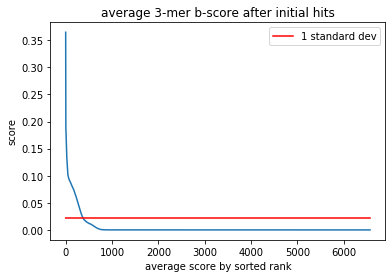

In [33]:
ml = max([len(l) for l in scoredistb])
for i in range(len(scoredistb)):
    scoredistb[i] = scoredistb[i] + [0 for _ in range(ml - len(scoredistb[i]))]
    
avgb = np.mean(scoredistb, axis=0)
stdb = np.std(scoredistb)
plt.plot(avgb)
plt.plot([stdb for _ in range(len(avgb))], 'r', label='1 standard dev')
plt.title('average 3-mer b-score after initial hits')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

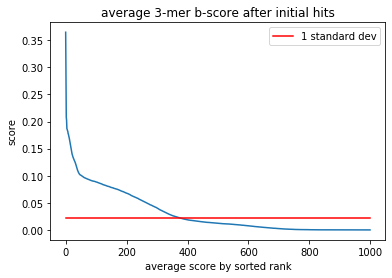

In [34]:
plt.plot(avgb[:1000])
plt.plot([stdb for _ in range(1000)], 'r', label='1 standard dev')
plt.title('average 3-mer b-score after initial hits')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

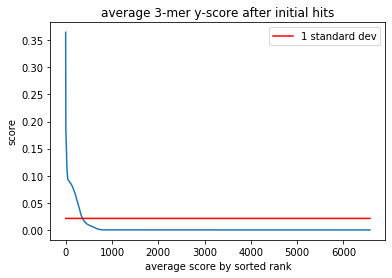

In [35]:
ml = max([len(l) for l in scoredisty])
for i in range(len(scoredisty)):
    scoredisty[i] = scoredisty[i] + [0 for _ in range(ml - len(scoredisty[i]))]
    
avgy = np.mean(scoredisty, axis=0)
stdy = np.std(scoredisty)
plt.plot(avgy)
plt.plot([stdy for _ in range(len(avgy))], 'r', label='1 standard dev')
plt.title('average 3-mer y-score after initial hits')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

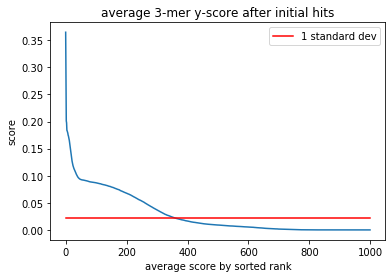

In [36]:
plt.plot(avgy[:1000])
plt.plot([stdy for _ in range(1000)], 'r', label='1 standard dev')
plt.title('average 3-mer y-score after initial hits')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()